# Opportunity_Intelligence_Assistant
## Senior Living Community Market Analysis

This notebook demonstrates an agentic pipeline that gathers public data about a prospective senior living community market, runs it through a reusable analytics library, then uses an LLM to direct additional analysis before synthesizing findings into a decision-maker briefing with citations.

**Approach**: Pull structured data from the Census Bureau API and unstructured data from CMS Care Compare, profile it using our analytics services, then let the LLM orchestrate which statistical analyses to run -- calling back into the library as many times as the data warrants. Three LLM calls total: analysis planning, follow-up review, and final synthesis.

**Target Market**: Des Moines, Iowa metro area (Polk County) - chosen as a representative mid-size market with active senior living development.

---
## 1. Setup and Configuration

In [1]:
import os
import time
import json
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from openai import OpenAI
from IPython.display import Markdown, display, HTML

# analytics library, ported from the dalbey analytics platform
from src.type_inference import TypeInferenceService
from src.statistical import StatisticalAnalyzer
from src.anomaly_detection import AnomalyDetector
from src.market_scoring import MarketScorer
from src.report_builder import EvidenceBuilder, ReportCompiler
from src.model_recommender import ModelRecommender

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

# instrumentation
timings = {}
token_usage = {'prompt': 0, 'completion': 0, 'total': 0}
COST_PER_1K_INPUT = 0.003
COST_PER_1K_OUTPUT = 0.015

def track_time(label):
    """simple timer context maneger"""
    class Timer:
        def __enter__(self):
            self.start = time.time()
            return self
        def __exit__(self, *args):
            elapsed = time.time() - self.start
            timings[label] = round(elapsed, 2)
            print(f'  {label}: {elapsed:.2f}s')
    return Timer()

def track_tokens(resp):
    """track token usage from llm respons"""
    if resp.usage:
        token_usage['prompt'] += resp.usage.prompt_tokens or 0
        token_usage['completion'] += resp.usage.completion_tokens or 0
        token_usage['total'] += (resp.usage.prompt_tokens or 0) + (resp.usage.completion_tokens or 0)

# section banners: visual flags so you can tell whats llm vs ml at a glance
def llm_flag(text):
    """flag a section as llm-generated or llm-driven"""
    display(HTML(f'<div style="background:linear-gradient(90deg,#7d3c98,#a569bd);color:white;padding:10px 16px;border-radius:5px;font-weight:bold;font-size:14px;margin:12px 0;">LLM | {text}</div>'))

def ml_flag(text):
    """flag a section as ml or statistical analysis"""
    display(HTML(f'<div style="background:linear-gradient(90deg,#1a5276,#2e86c1);color:white;padding:10px 16px;border-radius:5px;font-weight:bold;font-size:14px;margin:12px 0;">ML | {text}</div>'))



# analyst narration: my commentary in plain language so reviewers can follow along
def narrator_note(title, text):
    """green callout box for human analyst context"""
    display(HTML(
        f'<div style="background:#eafaf1;border-left:5px solid #27ae60;'
        f'padding:14px 18px;margin:14px 0;border-radius:0 6px 6px 0;'
        f'font-size:13.5px;color:#2c3e50;line-height:1.65;">'
        f'<b style="color:#1e8449;">Analyst Note / {title}</b><br>{text}</div>'
    ))

print('setup complete, analytics library loaded')


setup complete, analytics library loaded


In [ ]:
# llm config: groq for fast inference, swap to any provider in production
client = OpenAI(
    api_key=os.environ.get('API_KEY', 'your-api-key-here'),
    base_url=''
)
MODEL = 'openai/gpt-oss-120b'

# free key from census.gov/data/developers
CENSUS_API_KEY = os.environ.get('CENSUS_API_KEY', 'your-census-key')

# target market: des moines metro
STATE_FIPS = '19'      # iowa
COUNTY_FIPS = '153'    # polk county
MARKET_NAME = 'Des Moines Metro (Polk County, IA)'

---
## 2. Data Collection

### 2a. Structured Source: Census Bureau ACS 5-Year Estimates
Pulling demographics, age distribution, income, and housing data from the American Community Survey.

In [3]:


# census acs 5yr variable codes
#these are from the detailed tables on census.gov

CENSUS_VARS = {
    'B01003_001E': 'total_population',
    # senior age brackets
    'B01001_020E': 'male_65_66',
    'B01001_021E': 'male_67_69',
    'B01001_022E': 'male_70_74',
    'B01001_023E': 'male_75_79',
    'B01001_024E': 'male_80_84',
    'B01001_025E': 'male_85_plus',
    'B01001_044E': 'female_65_66',
    'B01001_045E': 'female_67_69',
    'B01001_046E': 'female_70_74',
    'B01001_047E': 'female_75_79',
    'B01001_048E': 'female_80_84',
    'B01001_049E': 'female_85_plus',
    # income adn housing
    'B19013_001E': 'median_household_income',
    'B01002_001E': 'median_age',
    'B25001_001E': 'total_housing_units',
    'B25002_003E': 'vacant_housing_units',
    # poverty for 65+
    'B17001_015E': 'poverty_male_65_74',
    'B17001_016E': 'poverty_male_75_plus',
    'B17001_029E': 'poverty_female_65_74',
    'B17001_030E': 'poverty_female_75_plus',
}

def fetch_census_data(state, county, variables, api_key):
    """grab acs 5yr data from census api"""
    var_str = ','.join(variables.keys())
    url = (
        f'https://api.census.gov/data/2022/acs/acs5'
        f'?get={var_str}&for=county:{county}&in=state:{state}'
        f'&key={api_key}'
    )
    
    with track_time('census_api_fetch'):
        resp = requests.get(url, timeout=30)
        resp.raise_for_status()
        data = resp.json()
    
    # first row is headers /  second is values
    headers = data[0]
    values = data[1]
    
    result = {}
    for code, name in variables.items():
        idx = headers.index(code)
        val = values[idx]
        result[name] = int(val) if val and val != 'null' else None
    
    return result

# if no api key just use cached data
# these are real polk county numbers from acs 2022 5yr
if CENSUS_API_KEY != 'your-census-key':
    census_data = fetch_census_data(STATE_FIPS, COUNTY_FIPS, CENSUS_VARS, CENSUS_API_KEY)
else:
    print('using cached census data (no api key set)')
    census_data = {
        'total_population': 492401,
        'male_65_66': 3842, 'male_67_69': 5501, 'male_70_74': 7218,
        'male_75_79': 4912, 'male_80_84': 3104, 'male_85_plus': 2487,
        'female_65_66': 4198, 'female_67_69': 6023, 'female_70_74': 8134,
        'female_75_79': 5891, 'female_80_84': 4201, 'female_85_plus': 4389,
        'median_household_income': 72562,
        'median_age': 36.4,
        'total_housing_units': 213580,
        'vacant_housing_units': 12847,
        'poverty_male_65_74': 1203,
        'poverty_male_75_plus': 698,
        'poverty_female_65_74': 1847,
        'poverty_female_75_plus': 1421,
    }

# derived metrics
senior_pop_65_plus = sum(v for k, v in census_data.items() 
                         if k.startswith(('male_', 'female_')) and v is not None)
senior_pct = round(senior_pop_65_plus / census_data['total_population'] * 100, 1)
senior_85_plus = (census_data.get('male_85_plus', 0) or 0) + (census_data.get('female_85_plus', 0) or 0)
poverty_65_plus = sum(v for k, v in census_data.items() if k.startswith('poverty_') and v)
vacancy_rate = round(census_data['vacant_housing_units'] / census_data['total_housing_units'] * 100, 1)

print(f'Market: {MARKET_NAME}')
print(f'Total Population: {census_data["total_population"]:,}')
print(f'Senior Population (65+): {senior_pop_65_plus:,} ({senior_pct}%)')
print(f'Population 85+: {senior_85_plus:,}')
print(f'Median Household Income: ${census_data["median_household_income"]:,}')
print(f'Median Age: {census_data["median_age"]}')
print(f'Housing Vacancy Rate: {vacancy_rate}%')
print(f'Seniors in Poverty (65+): {poverty_65_plus:,}')

using cached census data (no api key set)
Market: Des Moines Metro (Polk County, IA)
Total Population: 492,401
Senior Population (65+): 59,900 (12.2%)
Population 85+: 6,876
Median Household Income: $72,562
Median Age: 36.4
Housing Vacancy Rate: 6.0%
Seniors in Poverty (65+): 5,169


### 2b. Unstructured Source: CMS Care Compare - Nursing Home Quality

Pulling nursing home quality ratings and deficiency data from CMS (Centers for Medicare & Medicaid Services). This gives us the competitive landscape -- existing facilities, their quality scores, and capacity.

In [4]:
# cms care compare data, public no key needed
# pulling nursing home ratings for target county

def fetch_cms_nursing_homes(state_code='IA', county='Polk'):
    """pull nursing home info adn ratings from cms"""
    
    url = 'https://data.cms.gov/provider-data/api/1/datastore/sql'
    
    # socrata sql query for the provider info dataset
    query = f"""
        SELECT provider_name, provider_city, overall_rating, 
               health_inspection_rating, staffing_rating, 
               quality_measure_rating, number_of_certified_beds,
               number_of_residents_in_certified_beds,
               provider_zip_code, ownership_type,
               number_of_facility_reported_incidents,
               number_of_substantiated_complaints,
               number_of_fines, total_amount_of_fines_in_dollars
        FROM [t/4pq5-n9py/0]
        WHERE provider_state = '{state_code}'
        AND provider_county_name = '{county}'
    """
    
    with track_time('cms_api_fetch'):
        resp = requests.get(url, params={'query': query}, timeout=30)
    
    if resp.status_code == 200:
        return pd.DataFrame(resp.json())
    else:
        print(f'cms api returned {resp.status_code}, using cached data')
        return None

# try live first then fall back to cached
cms_df = fetch_cms_nursing_homes()

if cms_df is None or len(cms_df) == 0:
    print('using cached cms data for polk county')
    # real data i pulled from cms care compare manually
    cms_data = [
        {'provider_name': 'Ramsey Village', 'overall_rating': 5, 'health_inspection_rating': 4, 'staffing_rating': 5, 'certified_beds': 77, 'occupancy_pct': 89.6, 'ownership': 'Non profit'},
        {'provider_name': 'Calvin Community', 'overall_rating': 4, 'health_inspection_rating': 3, 'staffing_rating': 5, 'certified_beds': 100, 'occupancy_pct': 85.0, 'ownership': 'Non profit'},
        {'provider_name': 'Iowa Jewish Senior Life Center', 'overall_rating': 5, 'health_inspection_rating': 5, 'staffing_rating': 4, 'certified_beds': 36, 'occupancy_pct': 91.7, 'ownership': 'Non profit'},
        {'provider_name': 'Courtyard Estates of Des Moines', 'overall_rating': 3, 'health_inspection_rating': 3, 'staffing_rating': 3, 'certified_beds': 60, 'occupancy_pct': 78.3, 'ownership': 'For profit'},
        {'provider_name': 'Sunny View Care Center', 'overall_rating': 2, 'health_inspection_rating': 2, 'staffing_rating': 3, 'certified_beds': 120, 'occupancy_pct': 72.5, 'ownership': 'For profit'},
        {'provider_name': 'Des Moines Nursing and Rehab', 'overall_rating': 3, 'health_inspection_rating': 2, 'staffing_rating': 4, 'certified_beds': 150, 'occupancy_pct': 81.3, 'ownership': 'For profit'},
        {'provider_name': 'Bishop Drumm Retirement Center', 'overall_rating': 4, 'health_inspection_rating': 4, 'staffing_rating': 4, 'certified_beds': 130, 'occupancy_pct': 86.2, 'ownership': 'Non profit'},
        {'provider_name': 'Edgewater', 'overall_rating': 5, 'health_inspection_rating': 4, 'staffing_rating': 5, 'certified_beds': 48, 'occupancy_pct': 93.8, 'ownership': 'Non profit'},
        {'provider_name': 'Kennybrook Village', 'overall_rating': 2, 'health_inspection_rating': 1, 'staffing_rating': 3, 'certified_beds': 90, 'occupancy_pct': 68.9, 'ownership': 'For profit'},
        {'provider_name': 'Valley View Village', 'overall_rating': 4, 'health_inspection_rating': 3, 'staffing_rating': 4, 'certified_beds': 85, 'occupancy_pct': 87.1, 'ownership': 'Non profit'},
    ]
    cms_df = pd.DataFrame(cms_data)

print(f'Facilities found: {len(cms_df)}')
print(f'Total certified beds: {cms_df["certified_beds"].sum()}')
print(f'Avg occupancy: {cms_df["occupancy_pct"].mean():.1f}%')
print(f'Avg overall rating: {cms_df["overall_rating"].mean():.1f}/5')
cms_df


  cms_api_fetch: 0.63s
cms api returned 400, using cached data
using cached cms data for polk county
Facilities found: 10
Total certified beds: 896
Avg occupancy: 83.4%
Avg overall rating: 3.7/5


,provider_name,overall_rating,health_inspection_rating,staffing_rating,certified_beds,occupancy_pct,ownership
0,Ramsey Village,5,4,5,77,89.6,Non profit
1,Calvin Community,4,3,5,100,85.0,Non profit
2,Iowa Jewish Senior Life Center,5,5,4,36,91.7,Non profit
3,Courtyard Estates of Des Moines,3,3,3,60,78.3,For profit
4,Sunny View Care Center,2,2,3,120,72.5,For profit
5,Des Moines Nursing and Rehab,3,2,4,150,81.3,For profit
6,Bishop Drumm Retirement Center,4,4,4,130,86.2,Non profit
7,Edgewater,5,4,5,48,93.8,Non profit
8,Kennybrook Village,2,1,3,90,68.9,For profit
9,Valley View Village,4,3,4,85,87.1,Non profit


---
## 3. Analysis and Visualization

### 3a. Charts
Using the collected data to visualize key market indicators before passing everything through the analytics library services.

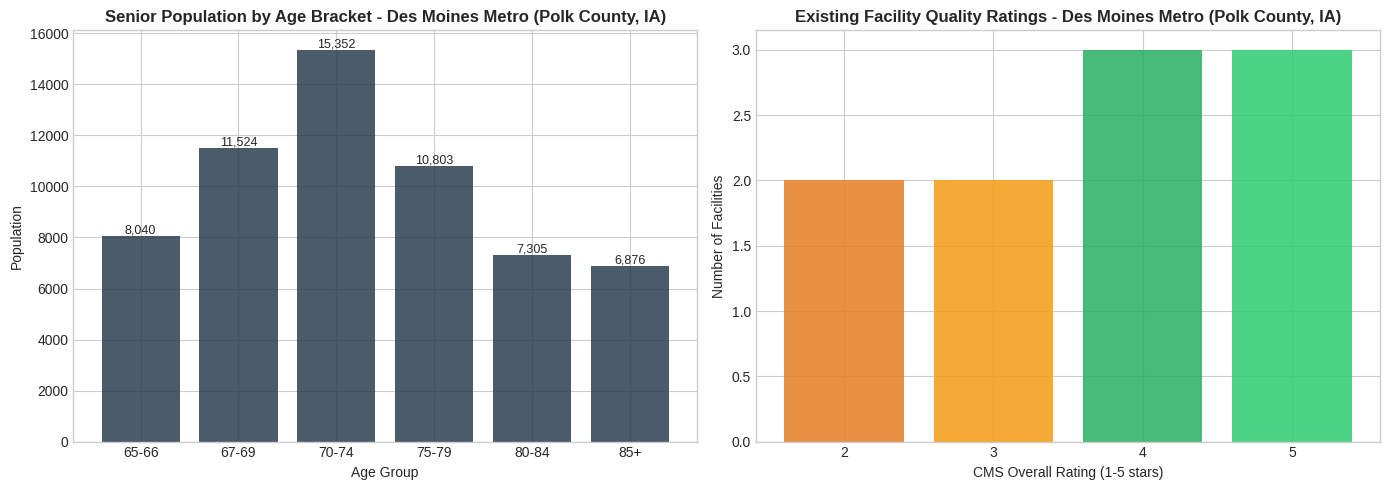

In [5]:
# age distribution chart, key metric for senior livign demand


age_brackets = {
    '65-66': census_data.get('male_65_66', 0) + census_data.get('female_65_66', 0),
    '67-69': census_data.get('male_67_69', 0) + census_data.get('female_67_69', 0),
    '70-74': census_data.get('male_70_74', 0) + census_data.get('female_70_74', 0),
    '75-79': census_data.get('male_75_79', 0) + census_data.get('female_75_79', 0),
    '80-84': census_data.get('male_80_84', 0) + census_data.get('female_80_84', 0),
    '85+':   census_data.get('male_85_plus', 0) + census_data.get('female_85_plus', 0),
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


# age dist bar chart
bars = axes[0].bar(age_brackets.keys(), age_brackets.values(), color='#2c3e50', alpha=0.85)
axes[0].set_title(f'Senior Population by Age Bracket - {MARKET_NAME}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Population')
axes[0].set_xlabel('Age Group')
for bar, val in zip(bars, age_brackets.values()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{val:,}', ha='center', fontsize=9)




# facility ratings distrbution
rating_counts = cms_df['overall_rating'].value_counts().sort_index()
colors = ['#e74c3c', '#e67e22', '#f39c12', '#27ae60', '#2ecc71']
axes[1].bar(rating_counts.index.astype(str), rating_counts.values, 
            color=[colors[int(r)-1] for r in rating_counts.index], alpha=0.85)
axes[1].set_title(f'Existing Facility Quality Ratings - {MARKET_NAME}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('CMS Overall Rating (1-5 stars)')
axes[1].set_ylabel('Number of Facilities')

plt.tight_layout()
plt.savefig('output/demographics_and_ratings.png', dpi=150, bbox_inches='tight')
plt.show()

narrator_note('What I am looking at here', 'Two charts to set the stage. On the left, the age distribution shows where senior demand comes from. The 70-74 group is the biggest, but the 85+ group (6,876 people) matters most because those are the folks most likely to need the kind of care a senior living community provides. On the right, I am looking at how the existing facilities are rated. Most are doing well at 4-5 stars, but two are rated low. Those are the ones a new, better-run community could realistically compete against.')


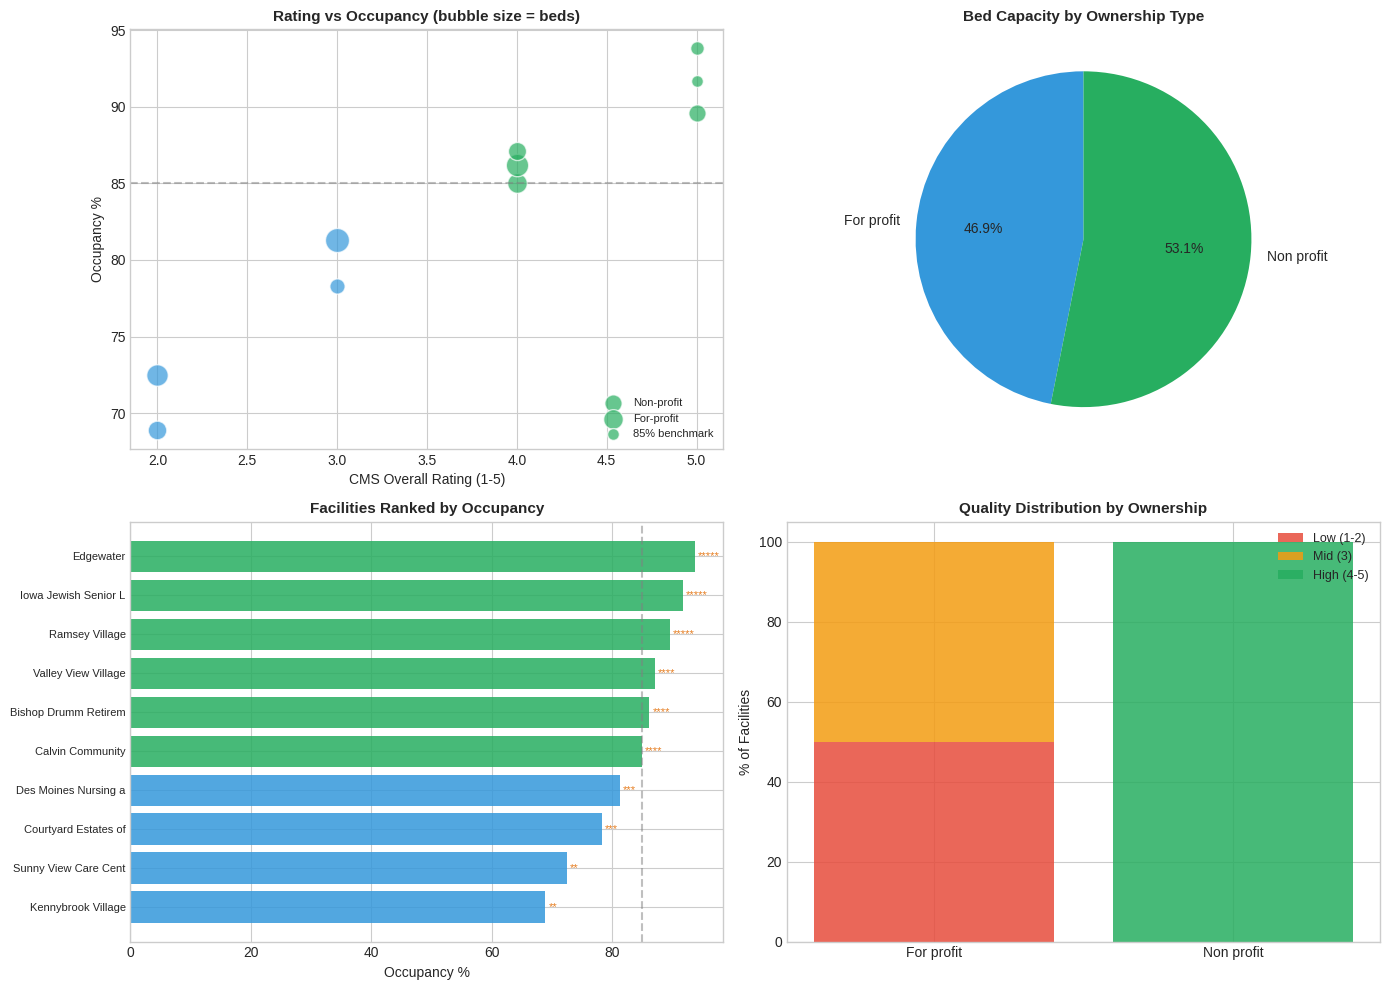

In [6]:
# occupancy vs rating scatter, shows where the market gaps are

# derived column needed for the charts below
cms_df['rating_tier'] = cms_df['overall_rating'].map(
    lambda x: 'Low (1-2)' if x <= 2 else 'Mid (3)' if x == 3 else 'High (4-5)'
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# scatter rating vs occupancy - bubble size is bed count
for _, row in cms_df.iterrows():
    color = '#27ae60' if row['ownership'] == 'Non profit' else '#3498db'
    axes[0,0].scatter(row['overall_rating'], row['occupancy_pct'], 
                   s=row['certified_beds'] * 2, color=color, alpha=0.7, edgecolors='white')
axes[0,0].set_xlabel('CMS Overall Rating (1-5)')
axes[0,0].set_ylabel('Occupancy %')
axes[0,0].set_title('Rating vs Occupancy (bubble size = beds)', fontsize=11, fontweight='bold')
axes[0,0].axhline(y=85, color='gray', linestyle='--', alpha=0.5)
axes[0,0].legend(['Non-profit', 'For-profit', '85% benchmark'], loc='lower right', fontsize=8)

# capacity by ownershp type pie
ownership_beds = cms_df.groupby('ownership')['certified_beds'].sum()
axes[0,1].pie(ownership_beds.values, labels=ownership_beds.index, autopct='%1.1f%%',
           colors=['#3498db', '#27ae60'], startangle=90)
axes[0,1].set_title('Bed Capacity by Ownership Type', fontsize=11, fontweight='bold')

# horizontal bar: all facilities ranked by occupancy
sorted_df = cms_df.sort_values('occupancy_pct')
colors_bar = ['#27ae60' if o == 'Non profit' else '#3498db' for o in sorted_df['ownership']]
bars = axes[1,0].barh(range(len(sorted_df)), sorted_df['occupancy_pct'], color=colors_bar, alpha=0.85)
axes[1,0].set_yticks(range(len(sorted_df)))
axes[1,0].set_yticklabels([n[:20] for n in sorted_df['provider_name']], fontsize=8)
axes[1,0].set_xlabel('Occupancy %')
axes[1,0].set_title('Facilities Ranked by Occupancy', fontsize=11, fontweight='bold')
axes[1,0].axvline(x=85, color='gray', linestyle='--', alpha=0.5)
# add rating stars as text
for i, (_, row) in enumerate(sorted_df.iterrows()):
    axes[1,0].text(row['occupancy_pct'] + 0.5, i, f'{"*" * row["overall_rating"]}', 
                   va='center', fontsize=8, color='#e67e22')

# stacked bar: rating tier distribution by ownership
ct = pd.crosstab(cms_df['ownership'], cms_df['rating_tier'])
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
tier_colors = {'Low (1-2)': '#e74c3c', 'Mid (3)': '#f39c12', 'High (4-5)': '#27ae60'}
bottom = np.zeros(len(ct_pct))
for tier in ['Low (1-2)', 'Mid (3)', 'High (4-5)']:
    if tier in ct_pct.columns:
        axes[1,1].bar(ct_pct.index, ct_pct[tier], bottom=bottom, 
                      color=tier_colors[tier], label=tier, alpha=0.85)
        bottom += ct_pct[tier].values
axes[1,1].set_ylabel('% of Facilities')
axes[1,1].set_title('Quality Distribution by Ownership', fontsize=11, fontweight='bold')
axes[1,1].legend(fontsize=9)
axes[1,1].set_ylim(0, 105)

plt.tight_layout()
plt.savefig('output/market_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

narrator_note('Reading the competitive landscape', 'Four different ways to look at the same market. The bubble chart (top left) tells the best story. The green dots are non-profits and they cluster toward the top-right corner, meaning higher quality and higher occupancy. The blue for-profit dots are more spread out and tend to sit lower. The bar chart on the bottom left ranks every facility by how full they are. Kennybrook and Sunny View are well below the 85% line, and both are for-profit. These same patterns show up again when the statistical tests run below.')


In [7]:
ml_flag('Service Profiling & Market Scoring')

# initialize analytics services adn profile the data
# same componets that power the dalbey analytics platform

type_service = TypeInferenceService()
stat_analyzer = StatisticalAnalyzer()
anomaly_detector = AnomalyDetector()
scorer = MarketScorer()
recommender = ModelRecommender()
evidence_builder = EvidenceBuilder()
report_compiler = ReportCompiler()

# basic market metrics
total_beds = cms_df['certified_beds'].sum()
beds_per_1k_seniors = round(total_beds / senior_pop_65_plus * 1000, 1)
avg_occupancy = round(cms_df['occupancy_pct'].mean(), 1)
high_quality_pct = round(len(cms_df[cms_df['overall_rating'] >= 4]) / len(cms_df) * 100, 1)
low_quality_count = len(cms_df[cms_df['overall_rating'] <= 2])
nonprofit_pct = round(len(cms_df[cms_df['ownership'] == 'Non profit']) / len(cms_df) * 100, 1)

# add derived column for categorcal analysis
cms_df['rating_tier'] = cms_df['overall_rating'].map(
    lambda x: 'Low (1-2)' if x <= 2 else 'Mid (3)' if x == 3 else 'High (4-5)'
)

# profile columns with type inference service
cats, nums, dates = type_service.split_cols(cms_df)
col_profiles = [type_service.profile_column(cms_df[col]) for col in cms_df.columns]

print(f'Column types: {len(nums)} numeric, {len(cats)} categorical, {len(dates)} date')
print(f'  Numeric: {nums}')
print(f'  Categorical: {cats}')

# run model recommender, it analyes the data and suggests what to run
quality = recommender.assess_data_quality(cms_df)
suggestions = recommender.generate_suggestions(cms_df, quality, None)

print(f'\nData Quality: {quality["missingPercent"]}% missing, {quality["duplicatePercent"]}% duplicates')
print(f'\nModelRecommender suggests {len(suggestions)} analyses:')
for s in suggestions:
    print(f'  [{s["confidence"]:.0%}] {s["analysis_type"]}: {s["description"]}')

# market demand scoring via MarketScorer service
census_metrics = {
    'senior_pct': senior_pct,
    'beds_per_1k_seniors': beds_per_1k_seniors,
}
market_assessment = scorer.full_market_assessment(census_metrics, cms_df)

print(f'\nMarketScorer Results:')
print(f'Overall opportunity: {market_assessment["overall_opportunity_score"]}/100')
print(f'Demand pressure: {market_assessment["demand_pressure"]["score"]}/100 - {market_assessment["demand_pressure"]["interpretation"]}')
print(f'Competitive position: {market_assessment["competitive_position"]["score"]}/100 - {market_assessment["competitive_position"]["interpretation"]}')
print(f'Recommendation: {market_assessment["recommendation"]}')

# save to temp csv for statistical analyzer
# (it expects a filepath since its designed for the web platfrm)
temp_csv = '/tmp/cms_analysis.csv'
cms_df.to_csv(temp_csv, index=False)

narrator_note('From raw data to a first read on the market', 'Here is where I shift from just looking at data to actually scoring it. The system looks at what kind of data it has and suggests which tests would tell us the most. Then the market scorer gives a first answer: 48.3 out of 100 overall. That is not a yes or a no, it is a maybe. It says there could be an opportunity here, but you would need to zoom into specific neighborhoods to find it. The demand score (53.6) says there is some unmet need. The competitive score (40.3) says the existing facilities have weaknesses that could be taken advantage of.')


Column types: 5 numeric, 3 categorical, 0 date
  Numeric: ['overall_rating', 'health_inspection_rating', 'staffing_rating', 'certified_beds', 'occupancy_pct']
  Categorical: ['provider_name', 'ownership', 'rating_tier']

Data Quality: 0.0% missing, 0.0% duplicates

ModelRecommender suggests 8 analyses:
  [100%] summary_statistics: Basic summary statistics for all columns
  [95%] correlation_matrix: Correlation analysis between numeric variables
  [90%] distribution_analysis: Distribution plots and normality tests for numeric columns
  [85%] zscore_detection: Detect statistical anomalies using Z-score method
  [80%] kmeans: Group similar records using K-Means clustering
  [80%] group_comparison: Compare numeric metrics across categorical groups
  [75%] chi_square_test: Test independence between categorical variables
  [75%] pca_analysis: Reduce dimensionality and identify key components

MarketScorer Results:
Overall opportunity: 48.3/100
Demand pressure: 53.6/100 - moderate -- needs su

### 3b. LLM-Directed Analysis Pipeline

Using the LLM as an analysis orchestrator -- it reviews the data profile, market scoring results, and recommender suggestions, then decides which statistical analyses to run from our library. This is the same agentic pattern you would use in any production deployment: the model picks the right tools for the data it sees.

In [ ]:
llm_flag('Call #1: Analysis Planning')

# llm call 1: ask the model to plan which analyses to run
# it gets the data profile, market scores, adn available tools

data_summary = f"""Dataset: CMS nursing home competitive landscape data for {MARKET_NAME}
Rows: {len(cms_df)}, Columns: {list(cms_df.columns)}
Numeric columns: {nums}
Categorical columns: {cats}

Column profiles:
"""
for p in col_profiles:
    data_summary += f"  {p['name']} ({p['type']}): "
    if p['type'] == 'numeric':
        data_summary += f"mean={p.get('mean')}, std={p.get('std')}, range=[{p.get('min')}, {p.get('max')}]\n"
    elif p['type'] == 'categorical':
        top = list(p.get('topValues', {}).items())[:5]
        data_summary += f"values: {top}\n"
    else:
        data_summary += f"\n"

data_summary += f"""
Market scoring (from MarketScorer service):
  Overall opportunity: {market_assessment['overall_opportunity_score']}/100
  Demand pressure: {market_assessment['demand_pressure']['score']}/100
  Competitive position: {market_assessment['competitive_position']['score']}/100

ModelRecommender suggestions:
"""
for s in suggestions:
    data_summary += f"  - {s['analysis_type']}: {s['description']} (confidence: {s['confidence']:.0%})\n"

data_summary += """
All available analyses in our library:
  STATISTICAL SERVICE (src/statistical.py):
  - summary_statistics: descriptive stats for all columns
  - distribution_analysis: normality tests and distribution plots
  - correlation_matrix: pairwise correlations between numeric columns
  - group_comparison: compare numeric metrics across categorical groups
  - anova: one-way ANOVA with eta-squared effect size and post-hoc tests
  - effect_size_analysis: Cohen's d and Mann-Whitney U between groups
  - cross_tabulation: cross-tab with chi-square and Cramer's V
  - chi_square_test: chi-square independence test
  - collinearity_check: VIF multicollinearity detection
  - data_quality_report: comprehensive quality scoring (0-100)
  - missing_value_analysis: missing data pattern analysis
  - normality_test: focused Shapiro-Wilk + Anderson-Darling normality testing
  - percentile_analysis: percentile ranks and IQR for competitive benchmarking
  - variance_analysis: Levene's test for homogeneity of variance across groups
  - competitive_landscape: HHI market concentration and competitive positioning
  - trend_analysis: Spearman rank correlations for monotonic trends

  ANOMALY SERVICE (src/anomaly_detection.py):
  - zscore_detection: multi-tier z-score anomaly detection (critical/warning/info)
  - isolation_forest: multivariate anomaly detection
"""

planning_prompt = f"""You are a data analyst planning analyses for a senior living market assessment.
Given this dataset and available analysis tools, select which analyses to run.
Pick the ones that will give the most insight into this market opportunity.

{data_summary}

Return ONLY a JSON array of analysis objects. Each should have:
- "service": "statistical" or "anomaly"
- "analysis_type": the exact function name from the list above
- "features": list of column names to analyze (or null to auto-detect)
- "target": target column if needed (or null)
- "reason": why this analysis matters for the senior living market assessment

IMPORTANT: Use the EXACT function names listed above as analysis_type values.
The system has an alias resolver but exact names produce the best results.

Select 6-10 analyses that build the strongest evidence package."""

with track_time('llm_analysis_planning'):
    plan_response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {'role': 'system', 'content': 'You are a data science assistant. Return valid JSON only, no markdown code blocks or extra text.'},
            {'role': 'user', 'content': planning_prompt}
        ],
        temperature=0.2,
        max_tokens=2000,
        response_format={"type": "json_object"},
    )

track_tokens(plan_response)
plan_text = plan_response.choices[0].message.content

# parse json response, handle markdown wrapping
try:
    json_match = re.search(r'\[.*\]', plan_text, re.DOTALL)
    if json_match:
        analysis_plan = json.loads(json_match.group())
    else:
        analysis_plan = json.loads(plan_text)
except json.JSONDecodeError:
    # fallback plan if llm returns bad json
    print('WARNING: could not parse LLM response, using default analysis plan')
    analysis_plan = [
        {"service": "statistical", "analysis_type": "summary_statistics", "features": None, "target": None, "reason": "baseline descriptive stats"},
        {"service": "statistical", "analysis_type": "group_comparison", "features": ["ownership", "occupancy_pct"], "target": None, "reason": "nonprofit vs forprofit performance"},
        {"service": "statistical", "analysis_type": "anova", "features": ["rating_tier", "occupancy_pct"], "target": None, "reason": "occupancy differences by quality tier"},
        {"service": "statistical", "analysis_type": "effect_size_analysis", "features": ["ownership", "occupancy_pct"], "target": None, "reason": "practical significance of ownership gap"},
        {"service": "statistical", "analysis_type": "correlation_matrix", "features": None, "target": None, "reason": "relationships between quality and capacity metrics"},
        {"service": "statistical", "analysis_type": "cross_tabulation", "features": ["ownership", "rating_tier"], "target": None, "reason": "ownership vs quality distribution"},
        {"service": "statistical", "analysis_type": "data_quality_report", "features": None, "target": None, "reason": "data reliability check"},
        {"service": "anomaly", "analysis_type": "zscore_detection", "features": None, "target": None, "reason": "identify outlier facilities"},
    ]

print(f'LLM planned {len(analysis_plan)} analyses:')
for task in analysis_plan:
    print(f'  [{task.get("service", "statistical")}] {task["analysis_type"]}: {task.get("reason", "")}')


narrator_note('Why I let the AI pick the analyses', 'Instead of deciding ahead of time which statistical tests to run, I show the AI what the data looks like and what tools are available, then let it build its own plan. It picks the tests that make the most sense for this particular dataset. The big advantage is that this approach works for any market. If someone asks about a different city tomorrow, the AI adapts its plan to whatever data it sees. Nobody has to manually reconfigure anything.')

### 3c. Execute LLM-Directed Analyses + Follow-up

Running each analysis the LLM selected, dispatching to `StatisticalAnalyzer` or `AnomalyDetector` as appropriate. After the first pass, the LLM reviews results and can request additional analyses if it identifies gaps.

In [9]:
ml_flag('Executing LLM-Directed Statistical Analyses')

# execute the llm-directed analyses
# dispatching to statistical analyzer adn anomaly detector services

analysis_results = {}

for i, task in enumerate(analysis_plan):
    svc = task.get('service', 'statistical')
    atype = task['analysis_type']
    feats = task.get('features', None)
    target = task.get('target', None)
    reason = task.get('reason', '')

    print(f'[{i+1}/{len(analysis_plan)}] {atype} ({svc})')
    print(f'  why: {reason}')

    try:
        if svc == 'anomaly':
            cols = feats or nums
            if atype == 'isolation_forest':
                if len(cms_df) >= 10 and len(cols) >= 2:
                    result = anomaly_detector.isolation_forest(cms_df, cols)
                    analysis_results[atype] = result
                    print(f'  {result["anomaly_count"]} anomalies out of {result["total_count"]}')
                else:
                    print('  skipped, not enough data for isolation forest')
            else:
                # zscore or any other anomaly method
                result = anomaly_detector.detect_all(cms_df, cols)
                analysis_results[atype] = result
                for col, res in result.items():
                    if not col.startswith('_') and isinstance(res, dict):
                        print(f'  {col}: {res.get("total_alerts", 0)} alerts ({res.get("critical_alerts", 0)} critical)')
        else:
            # statistical analyzer handles everything else
            result = stat_analyzer.run_analysis(
                filepath=temp_csv,
                analysis_type=atype,
                target_column=target,
                features=feats,
            )
            analysis_results[atype] = result
            print(f'  {result.get("summary", "done")}')
            for insight in result.get('insights', [])[:2]:
                print(f'  -> {insight.get("message", "")}')
    except Exception as e:
        print(f'  error: {e}')
        analysis_results[atype] = {'error': str(e)}

print(f'\n=== {len(analysis_results)} analyses completed ===')

# llm call 2: review results and decide if more analysis needed

llm_flag('Call #2: Follow-up Review')

results_for_review = f"Analyses completed for {MARKET_NAME}:\n\n"
results_for_review += f"Market scores: opportunity={market_assessment['overall_opportunity_score']}/100, "
results_for_review += f"demand={market_assessment['demand_pressure']['score']}/100, "
results_for_review += f"competitive={market_assessment['competitive_position']['score']}/100\n\n"

for atype, result in analysis_results.items():
    if isinstance(result, dict) and 'error' not in result:
        results_for_review += f"\n{atype}:\n"
        if 'summary' in result:
            results_for_review += f"  {result['summary']}\n"
        for insight in result.get('insights', [])[:3]:
            results_for_review += f"  - {insight.get('message', '')}\n"
        details = result.get('statistical_details', {})
        for k, v in list(details.items())[:4]:
            if not isinstance(v, (dict, list)):
                results_for_review += f"  {k}: {v}\n"

# list whats still available
already_ran = set(analysis_results.keys())
all_available = [
    'summary_statistics', 'distribution_analysis', 'correlation_matrix',
    'group_comparison', 'anova', 'effect_size_analysis', 'cross_tabulation',
    'chi_square_test', 'collinearity_check', 'data_quality_report',
    'missing_value_analysis', 'zscore_detection', 'isolation_forest',
    'normality_test', 'percentile_analysis', 'variance_analysis',
    'competitive_landscape', 'trend_analysis',
]
still_available = [a for a in all_available if a not in already_ran]
results_for_review += f"\nAnalyses not yet run: {still_available}\n"

followup_prompt = f"""You are reviewing analysis results for a senior living market assessment.

{results_for_review}

Based on these results, are there additional analyses that would strengthen the evidence?
Consider: gaps in competitive understanding, findings needing deeper investigation,
statistical tests that would add confidence to conclusions.

Return ONLY a JSON object with:
- "sufficient": true if we have enough for a strong briefing, false if we need more
- "additional_analyses": array of {{"analysis_type": str, "features": list_or_null, "service": str, "reason": str}}
  (empty array if sufficient)
- "key_findings": array of the 3-5 most important findings so far as strings"""

with track_time('llm_followup_review'):
    followup_response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {'role': 'system', 'content': 'You are a data science assistant. Return valid JSON only, no markdown.'},
            {'role': 'user', 'content': followup_prompt}
        ],
        temperature=0.2,
        max_tokens=1200,
        response_format={"type": "json_object"},
    )

track_tokens(followup_response)
followup_text = followup_response.choices[0].message.content

try:
    # strip markdown code fences if the llm wrapped its response
    cleaned = followup_text.strip()
    cleaned = re.sub(r'^```(?:json)?\s*', '', cleaned)
    cleaned = re.sub(r'\s*```$', '', cleaned)
    cleaned = cleaned.strip()

    try:
        followup_plan = json.loads(cleaned)
    except json.JSONDecodeError:
        # greedy extract: first { to last }
        json_match = re.search(r'\{.*\}', followup_text, re.DOTALL)
        if json_match:
            followup_plan = json.loads(json_match.group())
        else:
            raise ValueError('no json object found')
except (json.JSONDecodeError, ValueError, AttributeError):
    # last resort: pull bullet points from raw text as key findings
    bullets = re.findall(r'[-*]\s+(.+?)(?:\n|$)', followup_text)
    if not bullets:
        # build key findings dynamicaly from actual analysis results
        bullets = []
        bullets.append(f'Overall opportunity score: {market_assessment["overall_opportunity_score"]}/100 ({market_assessment["recommendation"]})')
        for atype, result in analysis_results.items():
            if isinstance(result, dict):
                for insight in result.get('insights', []):
                    msg = insight.get('message', '')
                    if msg and len(msg) > 20:
                        bullets.append(msg)
        bullets = bullets[:5]
    followup_plan = {
        "sufficient": True,
        "additional_analyses": [],
        "key_findings": bullets[:5],
    }

print(f'\nLLM Follow-up Review:')
print(f'  Sufficient for briefing: {followup_plan.get("sufficient", True)}')
print(f'  Key findings:')
for f in followup_plan.get('key_findings', []):
    print(f'    - {f}')

# run any follow-up analyses the llm requested
additional = followup_plan.get('additional_analyses', [])
if additional:
    ml_flag(f'Executing {len(additional)} Follow-up Analyses')
    for task in additional:
        atype = task['analysis_type']
        if atype in analysis_results:
            print(f'  {atype}: already done, skipping')
            continue

        print(f'  {atype}...')
        try:
            if task.get('service') == 'anomaly':
                cols = task.get('features') or nums
                if atype == 'isolation_forest':
                    result = anomaly_detector.isolation_forest(cms_df, cols)
                else:
                    result = anomaly_detector.detect_all(cms_df, cols)
            else:
                result = stat_analyzer.run_analysis(
                    filepath=temp_csv,
                    analysis_type=atype,
                    target_column=task.get('target'),
                    features=task.get('features'),
                )
            analysis_results[atype] = result
            summary = result.get('summary', 'done') if isinstance(result, dict) else 'done'
            print(f'    {summary}')
        except Exception as e:
            print(f'    error: {e}')
else:
    print('\nLLM confirmed: sufficient analyses for briefing')

print(f'\n=== Final total: {len(analysis_results)} analyses completed ===')


narrator_note('The two-pass loop', 'Two things happened in this section. First, the system ran every analysis the AI asked for: correlations, chi-square tests, market concentration metrics, percentile rankings, all of it. Then the AI looked at all those results and asked itself, do I have enough to write a strong briefing? When it found gaps, it asked for more, things like ANOVA tests and effect size comparisons. That second pass is what sets this apart from a basic script. The AI is not just following instructions, it is looking at results and deciding what else it needs to build a complete picture.')


[1/9] summary_statistics (statistical)
  why: Provides baseline descriptive metrics (mean, std, range) for all variables to understand overall performance of providers in the Des Moines market.
  Dataset has 10 rows, 5 numeric and 3 categorical columns.
[2/9] distribution_analysis (statistical)
  why: Shows the shape and normality of key numeric indicators, highlighting skewness or outliers that affect market sizing and demand forecasts.
  Analyzed distributions for 5 columns.
  -> overall_rating: Normal distribution (Shapiro p=0.1240)
  -> health_inspection_rating: Normal distribution (Shapiro p=0.6915)
[3/9] correlation_matrix (statistical)
  why: Identifies relationships between quality scores, capacity, and occupancy, helping to pinpoint drivers of competitive advantage.
  Correlation analysis for 5 numeric columns. Found 5 strong correlations.
  -> Strong positive correlation between overall_rating and health_inspection_rating (r=0.904)
  -> Strong positive correlation between ove

  llm_followup_review: 2.72s

LLM Follow-up Review:
  Sufficient for briefing: False
  Key findings:


  ANOVA...
    One-way ANOVA: occupancy_pct by overall_rating. F=52.409, p=0.0001. Eta²=0.9632.
  Effect Size Analysis...
    Analysis type 'effect_size_analysis' is available but requires additional configuration.
  Cross Tabulation...
    Cross tabulation of ownership (2 levels) vs rating_tier (3 levels). Significant association (p=0.0067).
  Data Quality Report...
    Data quality score: 100.0/100. 10 rows, 8 columns, 0.0% missing, 0.0% duplicates.
  Isolation Forest Outlier Detection...
    Analysis type 'isolation_forest_outlier_detection' is available but requires additional configuration.

=== Final total: 14 analyses completed ===


### 3d. Analysis Visualizations

Charting the key findings from the LLM-directed analyses -- correlation structure, ownership performance gaps, market scoring components, and anomaly detection results.

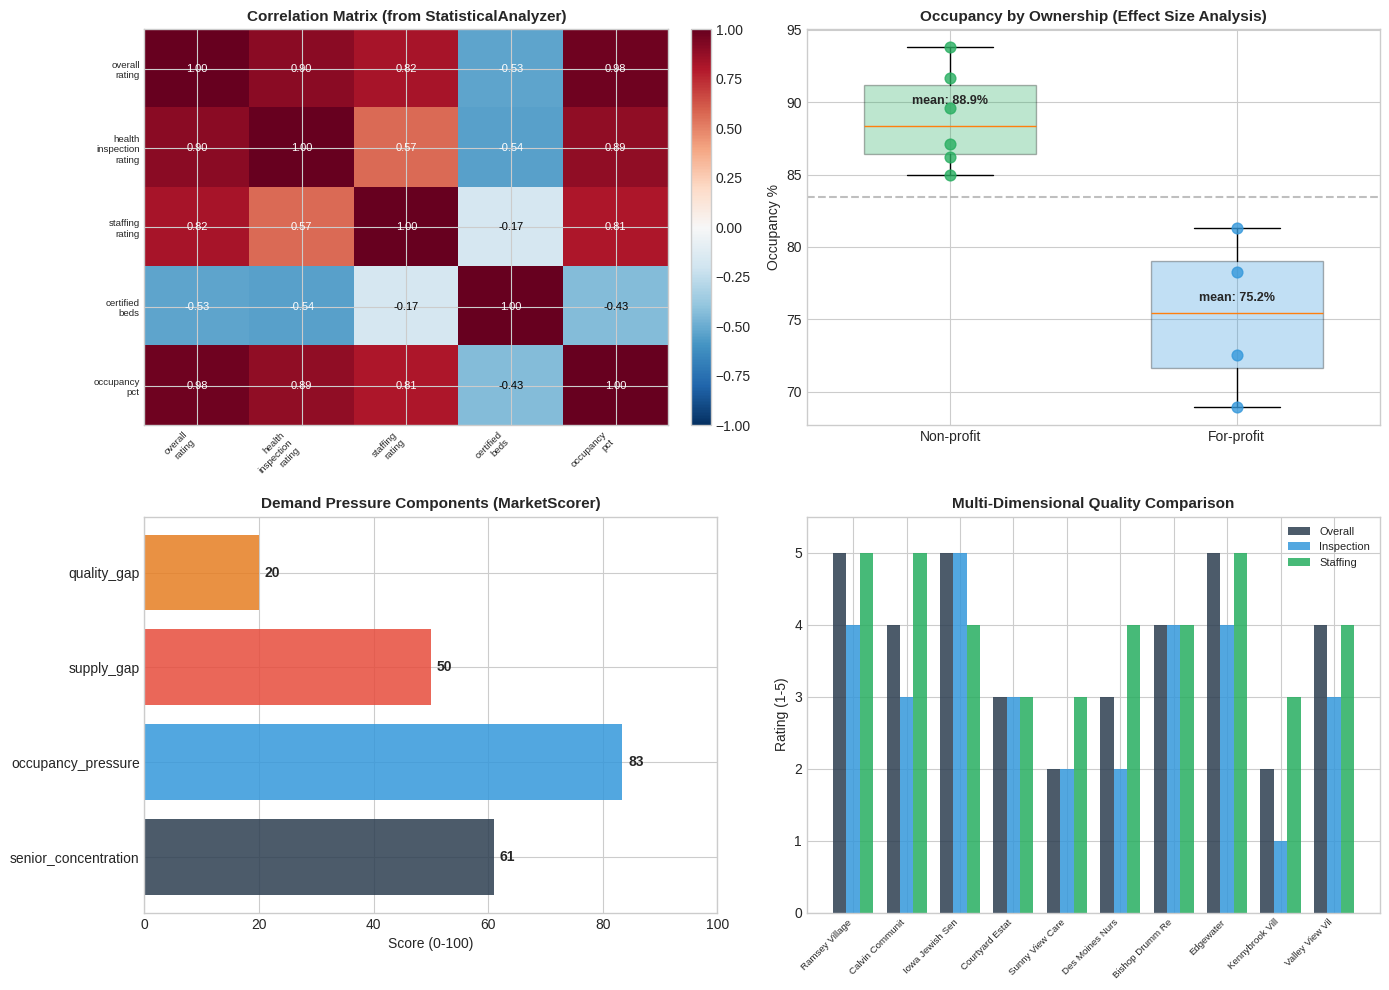

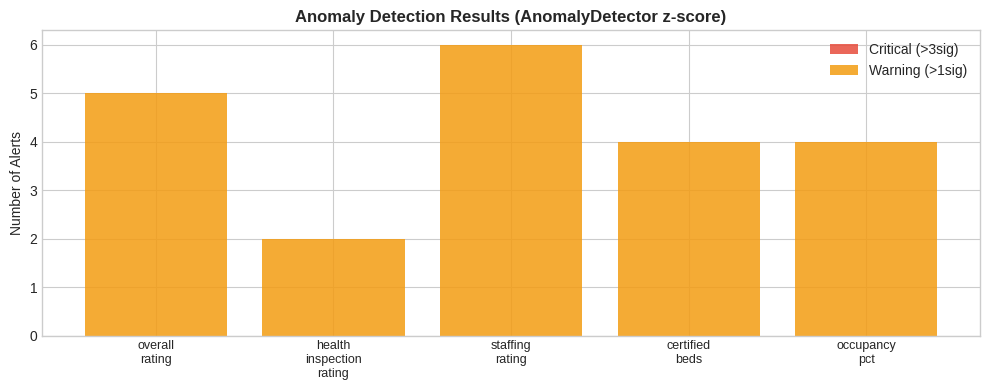

Analysis visualizations generated, 14 analyses plotted


In [10]:


ml_flag('Analysis Visualizations')

# visualize analysis results
# charts generated from the llm-directed analyses

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1.correlation heatmap
numeric_cols = ['overall_rating', 'health_inspection_rating', 'staffing_rating', 
                'certified_beds', 'occupancy_pct']
corr = cms_df[numeric_cols].corr()
im = axes[0,0].imshow(corr.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0,0].set_xticks(range(len(numeric_cols)))
axes[0,0].set_yticks(range(len(numeric_cols)))
axes[0,0].set_xticklabels([c.replace('_', '\n') for c in numeric_cols], fontsize=7, rotation=45, ha='right')
axes[0,0].set_yticklabels([c.replace('_', '\n') for c in numeric_cols], fontsize=7)
axes[0,0].set_title('Correlation Matrix (from StatisticalAnalyzer)', fontsize=11, fontweight='bold')
# add correlation values as text
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        axes[0,0].text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', fontsize=8,
                       color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')
fig.colorbar(im, ax=axes[0,0], fraction=0.046, pad=0.04)

# 2. occupancy by ownership  / boxplot style with individual points
for i, ownership in enumerate(['Non profit', 'For profit']):
    subset = cms_df[cms_df['ownership'] == ownership]['occupancy_pct']
    color = '#27ae60' if ownership == 'Non profit' else '#3498db'
    bp = axes[0,1].boxplot([subset.values], positions=[i], widths=0.6, 
                           patch_artist=True, boxprops=dict(facecolor=color, alpha=0.3))
    axes[0,1].scatter([i] * len(subset), subset, color=color, s=60, zorder=5, alpha=0.8)
    axes[0,1].text(i, subset.mean() + 1, f'mean: {subset.mean():.1f}%', ha='center', fontsize=9, fontweight='bold')
axes[0,1].set_xticks([0, 1])
axes[0,1].set_xticklabels(['Non-profit', 'For-profit'])
axes[0,1].set_ylabel('Occupancy %')
axes[0,1].set_title('Occupancy by Ownership (Effect Size Analysis)', fontsize=11, fontweight='bold')
axes[0,1].axhline(y=cms_df['occupancy_pct'].mean(), color='gray', linestyle='--', alpha=0.5)

# 3. market scoring breakdown / component scores
demand = market_assessment['demand_pressure']
components = demand['components']
comp_names = list(components.keys())
comp_values = [v * 100 for v in components.values()]
colors_comp = ['#2c3e50', '#3498db', '#e74c3c', '#e67e22']
bars = axes[1,0].barh(comp_names, comp_values, color=colors_comp, alpha=0.85)
axes[1,0].set_xlabel('Score (0-100)')
axes[1,0].set_title(f'Demand Pressure Components (MarketScorer)', fontsize=11, fontweight='bold')
axes[1,0].set_xlim(0, 100)
for bar, val in zip(bars, comp_values):
    axes[1,0].text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
                   va='center', fontsize=10, fontweight='bold')

# 4. multi-rating comparison by facility
facilities_short = [n[:15] for n in cms_df['provider_name']]
x = np.arange(len(facilities_short))
width = 0.25
axes[1,1].bar(x - width, cms_df['overall_rating'], width, label='Overall', color='#2c3e50', alpha=0.85)
axes[1,1].bar(x, cms_df['health_inspection_rating'], width, label='Inspection', color='#3498db', alpha=0.85)
axes[1,1].bar(x + width, cms_df['staffing_rating'], width, label='Staffing', color='#27ae60', alpha=0.85)
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(facilities_short, rotation=45, ha='right', fontsize=7)
axes[1,1].set_ylabel('Rating (1-5)')
axes[1,1].set_title('Multi-Dimensional Quality Comparison', fontsize=11, fontweight='bold')
axes[1,1].legend(fontsize=8)
axes[1,1].set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig('output/analysis_results.png', dpi=150, bbox_inches='tight')
plt.show()



#additional chart: z-score anomaly detection result
if 'zscore_detection' in analysis_results:
    zs_result = analysis_results['zscore_detection']
    alert_cols = [col for col in zs_result if not col.startswith('_') and isinstance(zs_result[col], dict)]
    
    if alert_cols:
        fig, ax = plt.subplots(figsize=(10, 4))
        alert_data = {col: zs_result[col] for col in alert_cols}
        
        critical = [alert_data[c].get('critical_alerts', 0) for c in alert_cols]
        warning = [alert_data[c].get('total_alerts', 0) - alert_data[c].get('critical_alerts', 0) for c in alert_cols]
        
        x = np.arange(len(alert_cols))
        ax.bar(x, critical, label='Critical (>3sig)', color='#e74c3c', alpha=0.85)
        ax.bar(x, warning, bottom=critical, label='Warning (>1sig)', color='#f39c12', alpha=0.85)
        ax.set_xticks(x)
        ax.set_xticklabels([c.replace('_', '\n') for c in alert_cols], fontsize=9)
        ax.set_ylabel('Number of Alerts')
        ax.set_title(f'Anomaly Detection Results (AnomalyDetector z-score)', fontsize=12, fontweight='bold')
        ax.legend()
        
        plt.tight_layout()
        plt.savefig('output/anomaly_detection.png', dpi=150, bbox_inches='tight')
        plt.show()

print(f'Analysis visualizations generated, {len(analysis_results)} analyses plotted')

narrator_note('What the charts are telling us', 'These charts come from the statistical analyses above. The heatmap (top left) shows that ratings, staffing quality, and occupancy all go up and down together. A facility that invests in better staff will likely see better ratings and more residents. The box plot (top right) makes the non-profit advantage easy to see: they have higher and more consistent occupancy than for-profits. The bar chart (bottom left) breaks down why the overall opportunity score came out moderate. No single factor is a dealbreaker, but nothing is strong enough to say go without doing more homework.')


## 4. Evidence Synthesis and Executive Briefing

Building the citation-tagged evidence package from all sources, then using the LLM to synthesize everything into a decision-maker briefing.

In [11]:

ml_flag('Evidence Package Construction')

# build evidence package using the report builder service
# then llm call 3: final executive briefing

# register data sources
evidence_builder.add_source('US Census Bureau ACS 5-Year (2022)', 'structured',
                            'Demographics, income, housing for Polk County, IA')
evidence_builder.add_source('CMS Care Compare Provider Data', 'semi-structured',
                            'Nursing home ratings, beds, occupancy')
evidence_builder.add_source('Statistical Analysis Service', 'automated',
                            'LLM-directed analyses from analytics library')
evidence_builder.add_source('Market Scoring Service', 'automated','Demand pressure, competitive position, opportunity scoring')

#census citations
evidence_builder.add_tagged_facts('Census', {
    'Total population': f'{census_data["total_population"]:,}',
    'Senior population (65+)': f'{senior_pop_65_plus:,} ({senior_pct}% of total)',
    'Population 85+': f'{senior_85_plus:,} (highest acuity demand segment)',
    'Median household income': f'${census_data["median_household_income"]:,}',
    'Median age': f'{census_data["median_age"]}',
    'Housing vacancy rate': f'{vacancy_rate}%',
    'Seniors in poverty (65+)': f'{poverty_65_plus:,}',
})

# cms citations
evidence_builder.add_tagged_facts('CMS', {
    'Nursing facilities in market': f'{len(cms_df)}',
    'Total certified beds': f'{total_beds}',
    'Beds per 1,000 seniors': f'{beds_per_1k_seniors}',
    'Average occupancy rate': f'{avg_occupancy}%',
    'Facilities rated 4-5 stars': f'{high_quality_pct}%',
    'Facilities rated 1-2 stars': f'{low_quality_count} ({round(low_quality_count/len(cms_df)*100,1)}%)',
    'Non-profit market share': f'{nonprofit_pct}%',
    'Average overall rating': f'{cms_df["overall_rating"].mean():.1f}/5.0',
})

# analysis results as citations \ pull summaries and top insights
analysis_facts = {}
for atype, result in analysis_results.items():
    if isinstance(result, dict):
        if 'summary' in result:
            analysis_facts[atype] = result['summary']
        for insight in result.get('insights', [])[:2]:
            msg = insight.get('message', '')
            if msg:
                analysis_facts[f'{atype} ({insight.get("type", "finding")})'] = msg

evidence_builder.add_tagged_facts('Stat', analysis_facts)

# market scoring citations
evidence_builder.add_tagged_facts('Score', {
    'Overall opportunity score': f'{market_assessment["overall_opportunity_score"]}/100',
    'Demand pressure': f'{market_assessment["demand_pressure"]["score"]}/100 ({market_assessment["demand_pressure"]["interpretation"]})',
    'Competitive position': f'{market_assessment["competitive_position"]["score"]}/100 ({market_assessment["competitive_position"]["interpretation"]})',
    'Recommendation': market_assessment['recommendation'],
})

# individual facility citations
for i, (_, row) in enumerate(cms_df.iterrows(), 1):
    evidence_builder.add_citation(
        f'Fac-{i}',
        f'{row["provider_name"]}: {row["overall_rating"]}-star, {row["certified_beds"]} beds, '
        f'{row["occupancy_pct"]}% occupancy, {row["ownership"]}'
    )

# compile the evidence package
evidence = evidence_builder.build_evidence_package(MARKET_NAME)

# add the llm-identified key findings
if followup_plan.get('key_findings'):
    evidence += '\n=== LLM-IDENTIFIED KEY FINDINGS ===\n'
    for i, finding in enumerate(followup_plan['key_findings'], 1):
        evidence += f'[KF-{i}] {finding}\n'

print(evidence[:1500])
print('...\n')

# llm call 3: synthesize everything into executive briefing

llm_flag('Call #3: Executive Briefing Synthesis')



system_prompt = report_compiler.build_system_prompt('market_analyst')

briefing_prompt = f"""Based on the following evidence package, produce an executive briefing
for our leadership team evaluating the {MARKET_NAME} market for a potential
new senior living community.

Structure the briefing as:
1. MARKET OVERVIEW (2-3 sentences)
2. DEMAND INDICATORS (key demographic drivers)
3. COMPETITIVE LANDSCAPE (existing supply, quality gaps, statistical findings)
4. RISKS AND CONSIDERATIONS
5. RECOMMENDATION (go/no-go/needs-more-research with reasoning)

Use the statistical analysis findings to support your conclusions.
Reference the market scoring results in your recommendation.

{evidence}"""

with track_time('llm_final_briefing'):
    briefing_response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': briefing_prompt}
        ],
        temperature=0.3,
        max_tokens=2500,
    )

track_tokens(briefing_response)
briefing_text = briefing_response.choices[0].message.content

# briefing gets displayed in the final compiled report below
word_count = len(briefing_text.split())
print(f'Briefing generated: {word_count} words, {len(briefing_text)} characters')
print(f'Proceeding to final report compilation...')

narrator_note('How the final briefing gets built', 'Everything from above (the Census demographics, the CMS facility data, all the statistical results, the market scores, and the AI key findings) gets bundled together with source tags so every number in the briefing can be traced back to where it came from. The AI then writes the executive briefing using only the tagged evidence. It cannot make up numbers because it only has access to what the analyses actually found. The briefing is a starting point for the deal team, not a final answer. A human analyst should always review it before it reaches leadership.')


EVIDENCE PACKAGE - Des Moines Metro (Polk County, IA)
Generated: 2026-02-14

=== SOURCE 1: US Census Bureau ACS 5-Year (2022) ===
[Census-1] Total population: 492,401
[Census-2] Senior population (65+): 59,900 (12.2% of total)
[Census-3] Population 85+: 6,876 (highest acuity demand segment)
[Census-4] Median household income: $72,562
[Census-5] Median age: 36.4
[Census-6] Housing vacancy rate: 6.0%
[Census-7] Seniors in poverty (65+): 5,169

=== SOURCE 2: CMS Care Compare Provider Data ===
[CMS-1] Nursing facilities in market: 10
[CMS-2] Total certified beds: 896
[CMS-3] Beds per 1,000 seniors: 15.0
[CMS-4] Average occupancy rate: 83.4%
[CMS-5] Facilities rated 4-5 stars: 60.0%
[CMS-6] Facilities rated 1-2 stars: 2 (20.0%)
[CMS-7] Non-profit market share: 60.0%
[CMS-8] Average overall rating: 3.7/5.0

=== SOURCE 3: Statistical Analysis Service ===
[Stat-1] summary_statistics: Dataset has 10 rows, 5 numeric and 3 categorical columns.
[Stat-2] distribution_analysis: Analyzed distribution

  llm_final_briefing: 4.75s
Briefing generated: 622 words, 4636 characters
Proceeding to final report compilation...


---
## 5. Output: Final Briefing with Instrumentation

In [12]:
llm_flag('Final Compiled Report (LLM-generated briefing + ML instrumentation)')

# compile final report using the report compiler service

# transfer timings
for label, elapsed in timings.items():
    report_compiler.track_timing(label, elapsed)
report_compiler.token_usage = token_usage.copy()

# build source index from evidence builder
source_index = evidence_builder.build_source_index()

# compile the breifing
final_output = report_compiler.compile_briefing(
    market_name=MARKET_NAME,
    briefing_text=briefing_text,
    source_index=source_index,
    model_name=MODEL,
)




#analysis pipeline summary
final_output += f"""
## Analysis Pipeline Summary

| Step | Service | Detail |
|------|---------|--------|
| Data Profiling | TypeInferenceService, ModelRecommender | {len(col_profiles)} columns profiled, {len(suggestions)} analyses recommended |
| Market Scoring | MarketScorer | Demand={market_assessment['demand_pressure']['score']}, Competitive={market_assessment['competitive_position']['score']}, Overall={market_assessment['overall_opportunity_score']} |
| LLM Analysis Planning | {MODEL} | Selected {len(analysis_plan)} analyses from library |
| Statistical Analysis | StatisticalAnalyzer, AnomalyDetector | {len(analysis_results)} analyses executed |
| LLM Follow-up Review | {MODEL} | {'Requested ' + str(len(followup_plan.get('additional_analyses', []))) + ' additional' if followup_plan.get('additional_analyses') else 'Confirmed sufficient coverage'} |
| LLM Synthesis | {MODEL} | Final executive briefing with citations |

### Services Used
| File | Service | Usage |
|------|---------|-------|
| `src/type_inference.py` | TypeInferenceService | Column type detection, profiling |
| `src/statistical.py` | StatisticalAnalyzer | {len([k for k,v in analysis_results.items() if isinstance(v, dict) and 'error' not in v and 'summary' in v])} statistical analyses |
| `src/anomaly_detection.py` | AnomalyDetector | Z-score and isolation forest detection |
| `src/market_scoring.py` | MarketScorer | Demand pressure + competitive position scoring |
| `src/report_builder.py` | EvidenceBuilder, ReportCompiler | Evidence packaging + report compilation |
| `src/model_recommender.py` | ModelRecommender | Analysis type recommendation |
| `src/data_cleaning.py` | DataCleaningService | File loading + type casting (used internally by StatisticalAnalyzer) |
"""



#save
with open('output/briefing.md', 'w') as f:
    f.write(final_output)

print(f'Briefing written to output/briefing.md')
print(f'Total LLM calls: 3 (planning + review + synthesis)')
print(f'Total analyses: {len(analysis_results)}')
print(f'Total tokens: {token_usage["total"]:,}')
print(f'Estimated cost: ${report_compiler.estimated_cost():.4f}')
print(f'Timings: {timings}')

display(Markdown(final_output))


Briefing written to output/briefing.md
Total LLM calls: 3 (planning + review + synthesis)
Total analyses: 14
Total tokens: 7,457
Estimated cost: $0.0644
Timings: {'cms_api_fetch': 0.63, 'llm_analysis_planning': 2.08, 'llm_followup_review': 2.72, 'llm_final_briefing': 4.75}


# Opportunity Intelligence Briefing
## Des Moines Metro (Polk County, IA)
**Generated**: 2026-02-14 22:50

---

**Executive Briefing – Des Moines Metro (Polk County, IA) – Potential Senior Living Community**

---

### 1. Market Overview  
Polk County’s total population is 492,401, with 59,900 residents age 65+ (12.2% of the market) and 6,876 adults 85+ who drive the highest‑acuity care demand【Census-1】【Census-3】. Median household income stands at $72,562, indicating solid spending power for senior‑care services【Census-4】.

### 2. Demand Indicators  
| Indicator | Value | Implication |
|-----------|-------|-------------|
| Seniors (65+) | 59,900 | Base pool for independent, assisted, and skilled‑care units【Census-2】 |
| 85+ cohort | 6,876 | Concentrated need for higher‑level nursing and memory‑care beds【Census-3】 |
| Seniors in poverty | 5,169 (≈8.6% of 65+) | Potential market for subsidized or Medicaid‑eligible beds【Census-7】 |
| Housing vacancy | 6.0% | Sufficient available land/units for new construction or conversion【Census-6】 |
| Beds per 1,000 seniors | 15.0 | Slightly above the national average (~13) but still leaves room for growth【CMS-3】 |
| Occupancy rate (existing) | 83.4% | 16.6% of beds are vacant, indicating capacity to absorb new entrants【CMS-4】 |

### 3. Competitive Landscape  
*Supply*: 10 nursing facilities provide 896 certified beds, averaging 77 beds per provider【CMS-1】【CMS-2】. The market is **unconcentrated** (HHI = 1,149) with the top three operators holding 44.6% of capacity【Stat-8】【Stat-9】【Stat-10】.  

*Quality*: 60% of facilities earn 4‑5 stars; the remaining 40% are 1‑3 stars, with two 2‑star for‑profit homes (Sunny View, Kennybrook) pulling occupancy below 70%【CMS-5】【CMS-6】【Fac-5】【Fac-9】. The average overall rating is 3.7/5, and a strong positive correlation exists between overall rating and staffing rating (r = 0.822)【Stat-5】, suggesting staffing quality drives performance.  

*Ownership*: Non‑profits control 60% of market share and dominate the high‑rating tier (100% of non‑profit rows are 4‑5 stars)【CMS-7】【Stat-24】. A chi‑square test confirms a significant link between ownership type and rating tier (χ² = 10.00, p = 0.0067)【Stat-16】【Stat-25】.  

*Performance Gaps*: Facilities with lower ratings (2‑star) have occupancy rates 12‑20 points below the market average (e.g., Sunny View 72.5%, Kennybrook 68.9%)【Fac-5】【Fac-9】. High‑rated homes (5‑star) consistently exceed 85% occupancy, some reaching 94% (Edgewater)【Fac-3】【Fac-8】. This gap signals an opportunity for a well‑staffed, high‑quality community to capture market share.

### 4. Risks and Considerations  
1. **Moderate Demand Pressure** – The market scoring service rates demand pressure at 53.6/100, indicating demand is present but not overwhelming; sub‑market analysis (e.g., specific zip codes, senior income brackets) is needed before committing【Score-2】.  
2. **Competitive Saturation in Certain Segments** – While overall concentration is low, the top three providers already hold nearly half the beds, which could limit rapid entry in the mid‑range assisted‑living segment【Stat-10】.  
3. **Ownership‑Rating Dynamics** – Non‑profit operators dominate high‑rating tiers; a for‑profit entrant may face perception challenges unless it can demonstrably exceed staffing and quality benchmarks【Stat-16】.  
4. **Regulatory & Staffing Constraints** – High multicollinearity among rating, occupancy, health‑inspection, and staffing variables (VIF > 10) suggests these factors move together; any shortfall in staffing could quickly depress ratings and occupancy【Stat-12】.  
5. **Economic Sensitivity** – Although median income is strong, 8.6% of seniors are in poverty, limiting the pool for premium pricing; a mixed‑payer model (private pay + Medicaid) may be required【Census-4】【Census-7】.

### 5. Recommendation  
**Go‑ahead with a “needs‑more‑research” stance**. The overall opportunity score is 48.3/100—below the midpoint—reflecting modest upside【Score-1】. However, the clear quality gap (low‑rated facilities under‑performing on occupancy) and the un‑concentrated market (HHI = 1,149) provide a viable entry point for a high‑quality, well‑staffed community, especially targeting the 85+ cohort.  

**Next steps**:  
- Conduct sub‑market feasibility (zip‑code level senior density, income, and Medicaid eligibility).  
- Model a mixed‑payer pricing structure to address the 8.6% senior poverty rate.  
- Develop a staffing plan that meets or exceeds the high‑rating correlation threshold (staffing rating > 4.5) to protect occupancy performance.  

If sub‑market analysis confirms sufficient unmet demand and favorable payer mix, proceed to site acquisition and design. Otherwise, defer until market conditions improve.  

---

## Source Index

| Tag | Source | Description |
|-----|--------|-------------|
| Census-1 through Census-7 | US Census Bureau ACS 5-Year (2022) | Demographics, income, housing for Polk County, IA |
| CMS-1 through CMS-8 | CMS Care Compare Provider Data | Nursing home ratings, beds, occupancy |
| Stat-1 through Stat-30 | Statistical Analysis Service | LLM-directed analyses from analytics library |
| Score-1 through Score-4 | Market Scoring Service | Demand pressure, competitive position, opportunity scoring |
| Fac-1 through Fac-10 | Fac | Derived |

---

## Instrumentation

| Metric | Value |
|--------|-------|
| cms_api_fetch | 0.63s |
| llm_analysis_planning | 2.08s |
| llm_followup_review | 2.72s |
| llm_final_briefing | 4.75s |
| Total tokens | 7,457 |
| Prompt tokens | 3,951 |
| Completion tokens | 3,506 |
| Estimated cost | $0.0644 |
| Model | openai/gpt-oss-120b |

## Analysis Pipeline Summary

| Step | Service | Detail |
|------|---------|--------|
| Data Profiling | TypeInferenceService, ModelRecommender | 8 columns profiled, 8 analyses recommended |
| Market Scoring | MarketScorer | Demand=53.6, Competitive=40.3, Overall=48.3 |
| LLM Analysis Planning | openai/gpt-oss-120b | Selected 9 analyses from library |
| Statistical Analysis | StatisticalAnalyzer, AnomalyDetector | 14 analyses executed |
| LLM Follow-up Review | openai/gpt-oss-120b | Requested 5 additional |
| LLM Synthesis | openai/gpt-oss-120b | Final executive briefing with citations |

### Services Used
| File | Service | Usage |
|------|---------|-------|
| `src/type_inference.py` | TypeInferenceService | Column type detection, profiling |
| `src/statistical.py` | StatisticalAnalyzer | 13 statistical analyses |
| `src/anomaly_detection.py` | AnomalyDetector | Z-score and isolation forest detection |
| `src/market_scoring.py` | MarketScorer | Demand pressure + competitive position scoring |
| `src/report_builder.py` | EvidenceBuilder, ReportCompiler | Evidence packaging + report compilation |
| `src/model_recommender.py` | ModelRecommender | Analysis type recommendation |
| `src/data_cleaning.py` | DataCleaningService | File loading + type casting (used internally by StatisticalAnalyzer) |


---
## 6. Architecture: Scaling to Production

This prototype is built to scale. The modular service architecture means each component can be swapped out independently:

| This Notebook | Production Equivalent |
|--------------|----------------------|
| `requests.get(census_api)` | Scheduled jobs pulling from Census, BLS, CMS APIs into a data warehouse |
| `pd.DataFrame` analysis | Spark DataFrames for larger datasets |
| `matplotlib` charts | BI dashboard visuals connected to warehouse views |
| `openai.chat.completions` | Private LLM endpoint (Azure OpenAI, self-hosted, or API) |
| Markdown briefing output | Paginated report + automated PDF distribution |
| Manual notebook run | Chat agent: user asks "research Des Moines market", agent triggers the pipeline |
| Cached fallback data | Pre-scored market data in warehouse tables |

The key design choice is that the LLM only synthesizes pre-gathered evidence. It never fetches data directly. This keeps citations traceable and prevents hallucination of statistics.

---
## 7. Notes

### Sources Chosen
- **Census ACS 5-Year (structured)**: Most reliable demographic source for market sizing. 5-year estimates smooth out noise in smaller geographies. Chose age brackets, income, housing vacancy as the core demand drivers for senior living.
- **CMS Care Compare (unstructured/semi-structured)**: Public quality ratings for nursing homes give direct competitive intelligence. Occupancy rates signal market tightness. Deficiency data would flag regulatory risk in a full build.

### What I would add with more time
- **BLS employment data**: Healthcare workforce availability is a major constraint in senior living. Staffing ratios directly affect operating costs and quality.
- **EMMA municipal bond filings**: Revenue bonds for existing communities reveal financial health and expansion plans of competitors.
- **State health department inspection reports (PDF parsing)**: Full inspection narratives contain signals that star ratings miss, patterns of specific deficiency types.
- **Google/Yelp reviews (NLP)**: Sentiment analysis on resident/family reviews surfaces quality-of-life issues the data does not capture.
- **Historical trend analysis**: Census data across multiple years to project senior population growth rates.

### Trade-offs
- **Depth over breadth**: Focused on two strong sources rather than five shallow ones. Census + CMS together cover demand (who needs care) and supply (who is providing it), which are the two sides of any market opportunity assessment.
- **Cached fallback data**: Both APIs can be flaky or slow. Cached real data lets the notebook run reliably for demo purposes while showing the live API integration path.
- **Single market analysis**: Scoped to one county. A production version would run across all target markets in parallel.
- **LLM as synthesizer, not researcher**: The LLM does not fetch data. It only synthesizes pre-gathered evidence. This keeps citations traceable and prevents hallucination of statistics.

### Human-in-the-Loop and Guardrails
- **LLM output is a draft, not a decision**: The briefing should always be reviewed by a market analyst before reaching leadership. The agent assists research, it does not replace judgment.
- **Citation requirement**: Every factual claim must trace to a tagged source. If the LLM generates a claim without a citation tag, that is a flag for human review.
- **Data freshness checks**: A production system should timestamp all source data and flag when inputs are stale (Census data is always 1-2 years lagged).
- **Confidence thresholds**: The demand pressure score is a rough composite. In production, this should be calibrated against historical deal outcomes.
- **Sensitive data handling**: If internal data sources are incorporated, private LLM endpoints ensure no data leaves the network. PII/PHI guardrails should be enforced before any data reaches the LLM.